In [182]:

from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# for ML prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [183]:
#Initialize CoinGecko API client
try:
    cg = CoinGeckoAPI()
except Exception as e:
    print("Error initializing CoinGecko API:", e)


In [184]:
#define date range
end_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - datetime.timedelta(days=360)

In [185]:
#convert to unix timestamps in sec
start_ts = int(start_date.timestamp())
end_ts = int(end_date.timestamp())


In [186]:
#fetch historical market chart data in the defined range for btc
data = cg.get_coin_market_chart_range_by_id(id= 'bitcoin', vs_currency='usd', 
                                            from_timestamp= start_ts, to_timestamp=end_ts)

if not data or "prices" not in data:
    raise ValueError("No data returned from CoinGecko")#error handling in case API fails or limits you


In [187]:
# extract and prepare dataframes 
def prepare_df(raw_data, col_name):
    df = pd.DataFrame(raw_data, columns=['timestamp', col_name])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms')
    return df
#Convert raw CoinGecko [timestamp, value] lists to DataFrame with datetime.

In [188]:
price_df = prepare_df(data['prices'], 'price')
market_cap_df = prepare_df(data['market_caps'], 'market_cap')
volumes_df = prepare_df(data['total_volumes'], 'total_volume')

In [189]:
#merge into a single df on timestamp
historical_df = price_df.merge(market_cap_df, on='timestamp').merge(volumes_df, on='timestamp', how='outer')

historical_df = historical_df.sort_values("timestamp").reset_index(drop=True)#sort
print(f"Data sample:\n{historical_df.head(7)}")


Data sample:
   timestamp         price    market_cap  total_volume
0 2024-10-08  62287.390105  1.231092e+12  3.387888e+10
1 2024-10-09  62185.230424  1.229717e+12  2.862643e+10
2 2024-10-10  60597.150456  1.197736e+12  2.853075e+10
3 2024-10-11  60195.180738  1.189692e+12  2.948197e+10
4 2024-10-12  62392.340483  1.233357e+12  3.200866e+10
5 2024-10-13  63207.770621  1.249002e+12  1.766596e+10
6 2024-10-14  62829.533686  1.241242e+12  1.678455e+10


In [190]:
#check for missing values
print(historical_df.isnull().sum())


timestamp       0
price           0
market_cap      0
total_volume    0
dtype: int64


In [191]:
print(historical_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     360 non-null    datetime64[ns]
 1   price         360 non-null    float64       
 2   market_cap    360 non-null    float64       
 3   total_volume  360 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.4 KB
None


In [192]:
print(historical_df.describe().T)

              count                  mean                   min  \
timestamp       360   2025-04-05 12:00:00   2024-10-08 00:00:00   
price         360.0           98171.55763          60195.180738   
market_cap    360.0  1948867171611.448975  1189691671375.147217   
total_volume  360.0    45247793331.376839     7771134681.982918   

                              25%                   50%                   75%  \
timestamp     2025-01-05 18:00:00   2025-04-05 12:00:00   2025-07-04 06:00:00   
price                88726.182003          98904.482201         108955.776442   
market_cap    1758967696145.01123  1957683596781.047363  2167175020325.058105   
total_volume   26802474638.299721    39508122526.326569    53254285038.457932   

                               max                  std  
timestamp      2025-10-02 00:00:00                  NaN  
price                123560.993636         14398.738677  
market_cap    2458895200752.566895  289204635498.981934  
total_volume   19046029353

In [193]:
historical_df.quantile([0.01, 0.99]) #o check extreme values in crypto data.

,timestamp,price,market_cap,total_volume
0.01,2024-10-11 14:09:36,62349.310828,1.232428e+12,1.046707e+10
0.99,2025-09-28 09:50:24,119604.572002,2.379518e+12,1.348153e+11


In [194]:
# calculate daily return pecentage
historical_df['return_1d'] = historical_df['price'].pct_change()
#historical_df = historical_df.dropna(subset=['return_1d'])

In [195]:
#compute moving avg of price
historical_df['ma_7d'] = historical_df['price'].rolling(7, min_periods=1).mean()
historical_df['ma_30d'] = historical_df['price'].rolling(30, min_periods=1).mean()

'''Moving avgs smooth out short  term fluctuations and highlight longer term trends in return series, reducing
noise from daily volatility
'''

'Moving avgs smooth out short  term fluctuations and highlight longer term trends in return series, reducing\nnoise from daily volatility\n'

In [196]:
#calculating the ratio of ma 7d to the 30d ma
historical_df['ma_ration'] = historical_df['ma_7d']/historical_df['ma_30d']

'''shorter MA reacts quicker to changes than the longer MA their ratio provides a relative momentum indicator,
which can be useful in trading risk managment and understanding asset return dynamics
'''

'shorter MA reacts quicker to changes than the longer MA their ratio provides a relative momentum indicator,\nwhich can be useful in trading risk managment and understanding asset return dynamics\n'

In [197]:
historical_df['log_return'] = np.log(historical_df['price'] / historical_df['price'].shift(1))
#historical_df = historical_df.dropna(subset=['log_return'])

'''Log Return(continuously compounded return) this measures the continuous growth rate btw two prices using 
the natural logarithm of their ratio'''

'Log Return(continuously compounded return) this measures the continuous growth rate btw two prices using \nthe natural logarithm of their ratio'

In [198]:
#compute 7d 30d rolling volatility 
historical_df['volatility_7d'] = historical_df['log_return'].rolling(7).std()
#historical_df['volatility_30d'] = historical_df['log_return'].rolling(30).std()


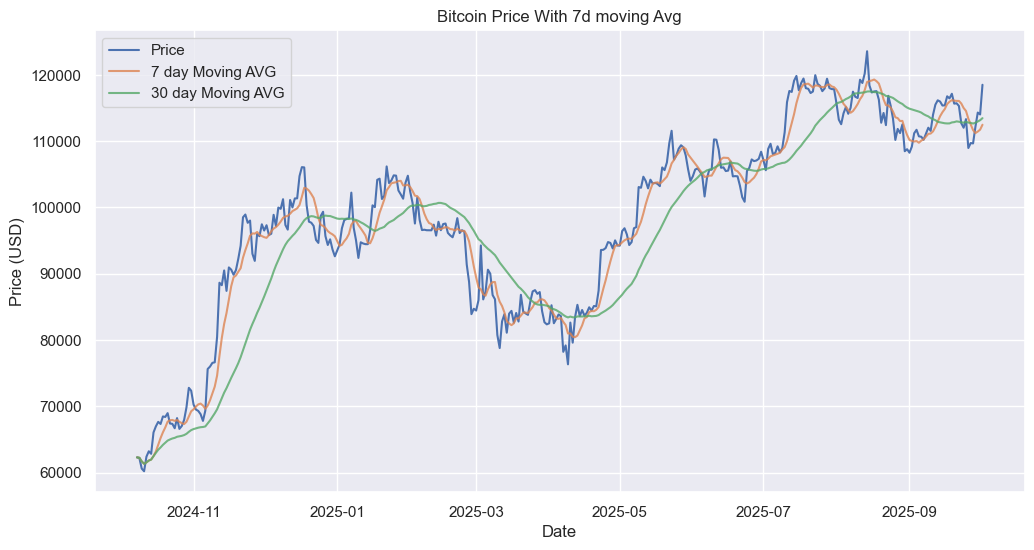

In [199]:
# visualize price trend
sns.set_theme()
plt.figure(figsize=(12, 6))
plt.plot(historical_df['timestamp'], historical_df['price'], label='Price')
plt.plot(historical_df['timestamp'], historical_df['ma_7d'], label= '7 day Moving AVG', alpha=0.8)
plt.plot(historical_df['timestamp'], historical_df['ma_30d'], label= '30 day Moving AVG', alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title('Bitcoin Price With 7d moving Avg')
plt.legend()
plt.show()


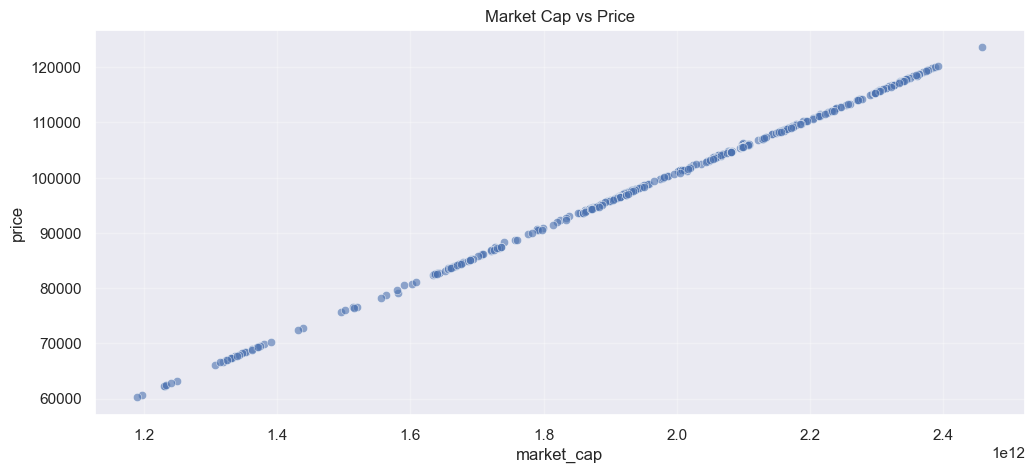

In [200]:
#market cap vs price
def scatter_plot(x, y, title):
    plt.figure(figsize=(12,5))
    sns.scatterplot(x=x, y=y, data=historical_df, alpha=0.6)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

scatter_plot('market_cap', 'price', 'Market Cap vs Price')


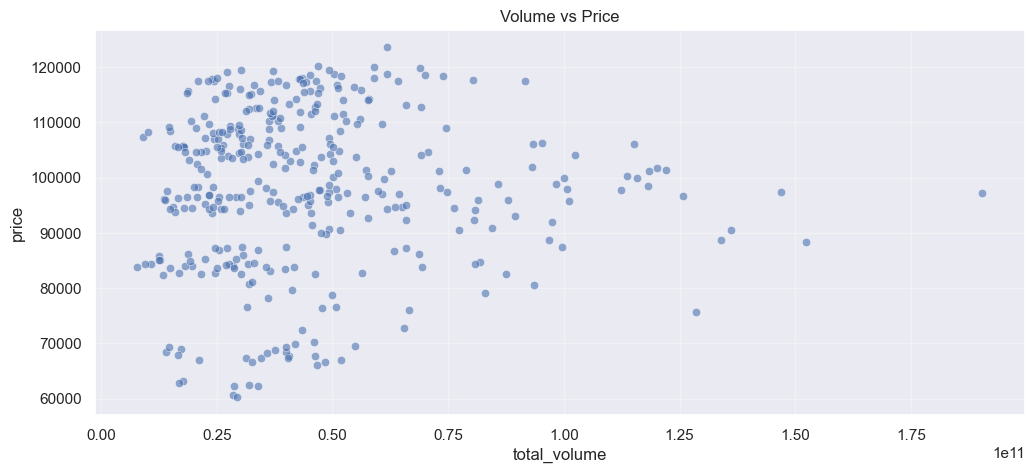

In [201]:
#volume vs price
scatter_plot('total_volume', 'price', 'Volume vs Price')

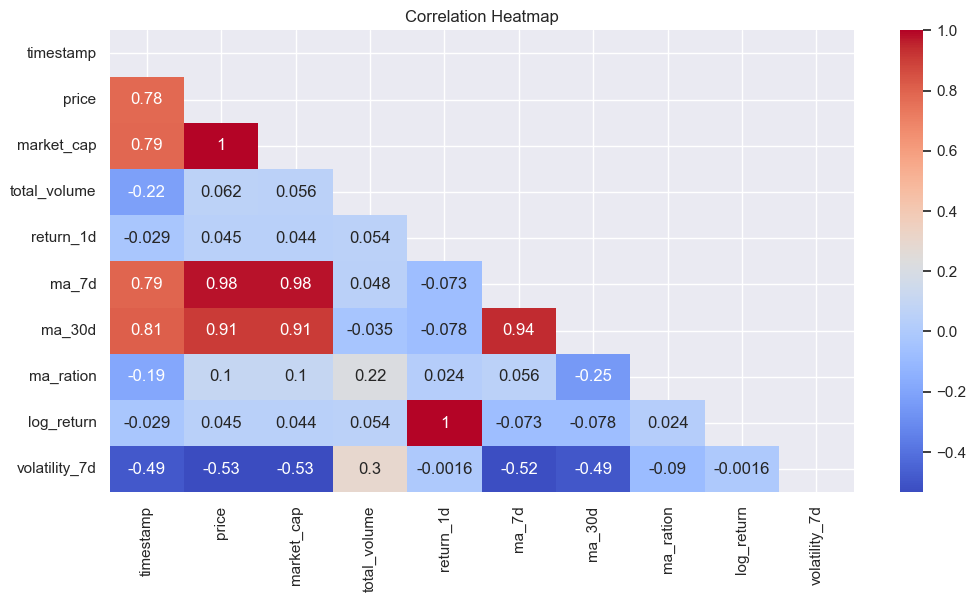

In [202]:
#calculating spearman corr matrix
corr = historical_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(12,6))
sns.heatmap(corr,mask=mask, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [203]:
#computing lag returns and vol
for lag in [1, 2, 3, 7, 14, 30]:
    historical_df[f'return_lag_{lag}'] = historical_df['return_1d'].shift(lag)#lagged daily return
    historical_df[f'volumn_lag_{lag}'] = historical_df['total_volume'].shift(lag)#lagged volume
    historical_df[f'volatility_lag_{lag}'] = historical_df['volatility_7d'].shift(lag)#lagged volatility 7d
   
# list of all the lagged cols
lag_cols = [f'return_lag_{lag}' for lag in [1, 2, 3, 7, 14, 30]] + \
    [f'volumn_lag_{lag}' for lag in [1, 2, 3, 7, 14, 30]] + \
        [f'volatility_lag_{lag}' for lag in [1, 2, 3, 7, 14, 30]]
#drop rows with any null in lag col
#historical_df = historical_df.dropna(subset=lag_cols)

#lag refer to looking backward in time at past data points in this case we look at past data points of 1d, 
#2d, 3d, 7d, 24d, and 30d this is helpful in predicting future price since return often depend on the past price

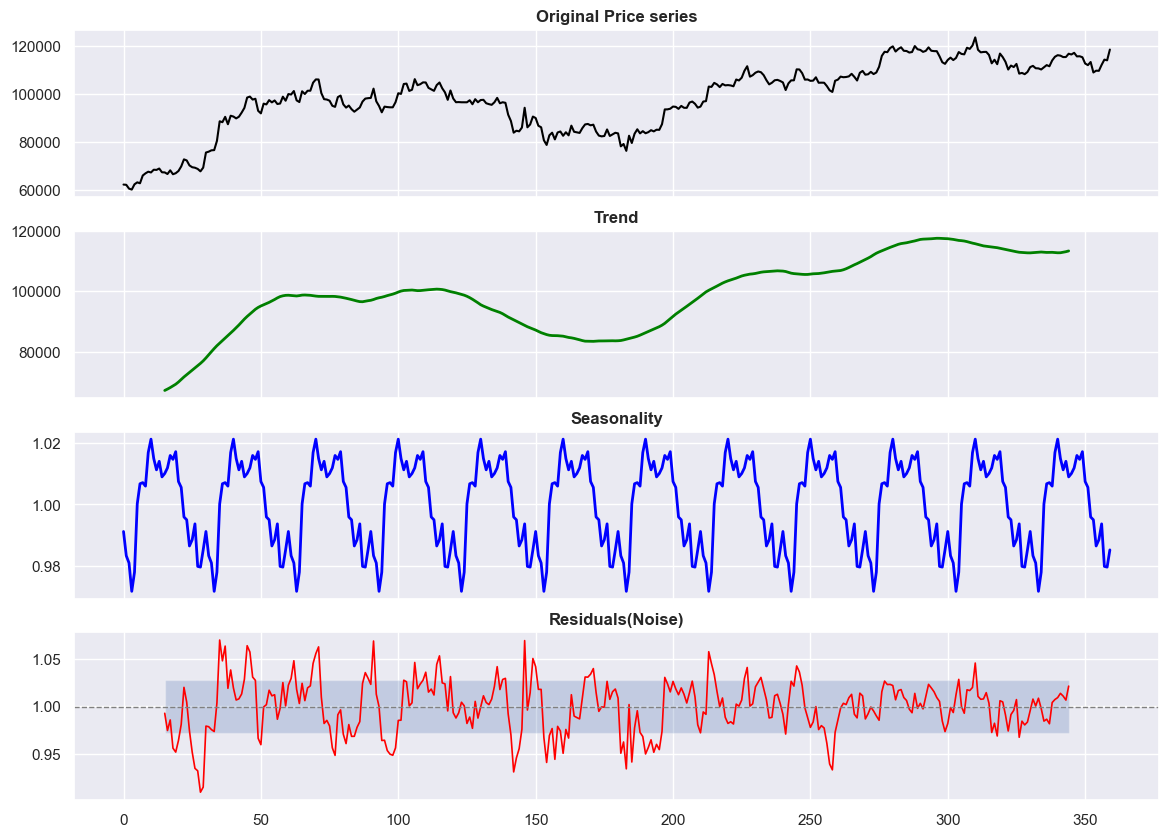

In [204]:
#Seasonal decomposition

result = seasonal_decompose(historical_df['price'], model='multiplicative', period=30)

fig, axes = plt.subplots(4,1, figsize=(14, 10), sharex=True)#clean the plot

axes[0].plot(historical_df.index, historical_df['price'], color='black', linewidth=1.5)# Original plot
axes[0].set_title('Original Price series', fontweight='bold')

axes[1].plot(result.trend.index, result.trend, color='green', linewidth=2)# Trend plot
axes[1].set_title('Trend', fontweight='bold')

axes[2].plot(result.seasonal.index, result.seasonal, color='blue', linewidth=2)# Seasonality plot
axes[2].set_title('Seasonality', fontweight='bold')

#Extracted Residuals and making sure its a clean numeric series
resid =result.resid
resid =pd.Series(resid)
resid= pd.to_numeric(resid, errors='coerce').dropna()
#add mean, -+1 std deviation line
mean_resid = resid.mean()
std_resid = resid.std()
# Residual plot with band
axes[3].plot(result.resid.index, result.resid, color='red', linewidth=1.2)
axes[3].axhline(mean_resid, color='grey', linestyle='--', linewidth=1,)
axes[3].set_title('Residuals(Noise)', fontweight='bold')
axes[3].fill_between(resid.index, mean_resid-std_resid, mean_resid+std_resid, alpha=0.25, label='-+1Std')

plt.show()

# store decomposition to df for ML later
historical_df['trend'] = result.trend
historical_df['seasonal'] = result.seasonal
historical_df['residual'] = result.resid


In [205]:
#Check if volume–price correlation changes over time
historical_df['roll_corr_vol_price7d'] = historical_df['price'].rolling(7).corr(historical_df['total_volume'])
historical_df['roll_corr_vol_price30d'] = historical_df['price'].rolling(30).corr(historical_df['total_volume'])
#historical_df['roll_corr_vol_price90d'] = historical_df['price'].rolling(90).corr(historical_df['total_volume'])



In [206]:
# --- Extreme Events Analysis (Top 5 Gains & Losses ) ---

# Drop NaN (because there’s no previous price on the first row to compare with)
returns = historical_df.dropna(subset=['return_1d'])

# Get top 5 biggest gains and losses
top_gains = returns.nlargest(5, 'return_1d')#selects the 5 rows with the highest percentage daily gains.
top_losses = returns.nsmallest(5, 'return_1d')#selects the 5 rows with the smallest percentage daily gains.

print("Top 5 Gain Days:\n", top_gains[['timestamp', 'return_1d']])
print("\nTop 5 Loss Days:\n", top_losses[['timestamp', 'return_1d']])

#store results in a dictionary for structured reporting
extremes_report = {
    "Top Gains": top_gains[['timestamp', 'return_1d']],
    "Top Losses": top_losses[['timestamp', 'return_1d']]
}

#this can indicate market shocks, high volatility periods or significant news impact

Top 5 Gain Days:
      timestamp  return_1d
35  2024-11-12   0.101541
146 2025-03-03   0.095997
30  2024-11-07   0.090653
184 2025-04-10   0.082447
197 2025-04-23   0.070028

Top 5 Loss Days:
      timestamp  return_1d
147 2025-03-04  -0.086322
181 2025-04-07  -0.064410
153 2025-03-10  -0.062592
142 2025-02-27  -0.054708
72  2024-12-19  -0.053561


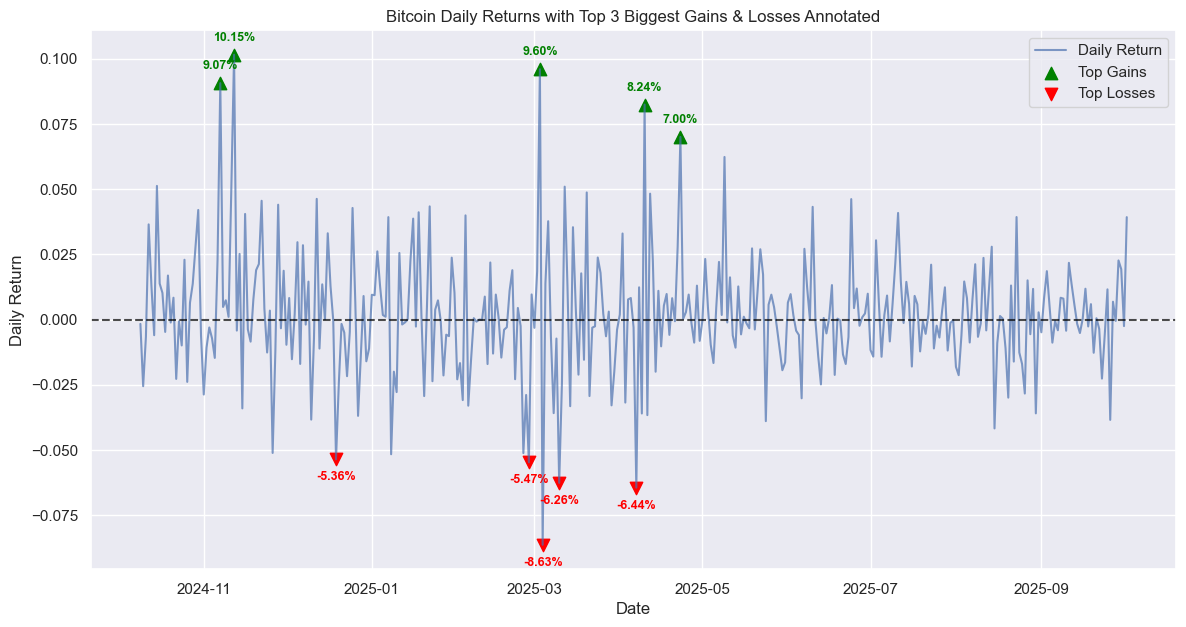

In [207]:
# --- Visualization ---
plt.figure(figsize=(14,7))
plt.plot(returns['timestamp'], returns['return_1d'], label='Daily Return', alpha=0.7)

# Highlight all extremes for context 
plt.scatter(top_gains['timestamp'], top_gains['return_1d'], 
            color='green', label='Top Gains', marker='^', s=80)
plt.scatter(top_losses['timestamp'], top_losses['return_1d'], 
            color='red', label='Top Losses', marker='v', s=80)

# Add annotations only for top 5 gain/loss days
for idx, row in top_gains.iterrows():
    plt.annotate(f"{row['return_1d']:.2%}", #formats the return as a percentage with 2 decimals
                 (row['timestamp'], row['return_1d']), #places the text at the same x-y position as the point.
                 textcoords="offset points", xytext=(0,10), ha='center',
                 fontsize=9, color='green', fontweight='bold')

for idx, row in top_losses.iterrows():
    plt.annotate(f"{row['return_1d']:.2%}", 
                 (row['timestamp'], row['return_1d']),
                 textcoords="offset points", xytext=(0,-15), ha='center', #xytext=(0,-15): shifts the label -15 points below the marker to avoid overlap.
                 fontsize=9, color='red', fontweight='bold')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title("Bitcoin Daily Returns with Top 3 Biggest Gains & Losses Annotated")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()


In [208]:
historical_df.head(20)

,timestamp,price,market_cap,total_volume,return_1d,ma_7d,ma_30d,ma_ration,log_return,volatility_7d,...,volumn_lag_14,volatility_lag_14,return_lag_30,volumn_lag_30,volatility_lag_30,trend,seasonal,residual,roll_corr_vol_price7d,roll_corr_vol_price30d
0,2024-10-08,62287.390105,1.231092e+12,3.387888e+10,NaN,62287.390105,62287.390105,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.991202,NaN,NaN,NaN
1,2024-10-09,62185.230424,1.229717e+12,2.862643e+10,-0.001640,62236.310264,62236.310264,1.000000,-0.001641,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.983313,NaN,NaN,NaN
2,2024-10-10,60597.150456,1.197736e+12,2.853075e+10,-0.025538,61689.923662,61689.923662,1.000000,-0.025870,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.980940,NaN,NaN,NaN
3,2024-10-11,60195.180738,1.189692e+12,2.948197e+10,-0.006633,61316.237931,61316.237931,1.000000,-0.006656,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.971698,NaN,NaN,NaN
4,2024-10-12,62392.340483,1.233357e+12,3.200866e+10,0.036501,61531.458441,61531.458441,1.000000,0.035850,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.977956,NaN,NaN,NaN
5,2024-10-13,63207.770621,1.249002e+12,1.766596e+10,0.013069,61810.843804,61810.843804,1.000000,0.012985,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000194,NaN,NaN,NaN
6,2024-10-14,62829.533686,1.241242e+12,1.678455e+10,-0.005984,61956.370930,61956.370930,1.000000,-0.006002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.006758,NaN,-0.485563,NaN
7,2024-10-15,66049.994927,1.306086e+12,4.655380e+10,0.051257,62493.885905,62468.073930,1.000413,0.049987,0.026499,...,NaN,NaN,NaN,NaN,NaN,NaN,1.007132,NaN,0.433390,NaN
8,2024-10-16,66962.219945,1.323775e+12,5.179793e+10,0.013811,63176.312979,62967.423487,1.003317,0.013717,0.026165,...,NaN,NaN,NaN,NaN,NaN,NaN,1.005984,NaN,0.680480,NaN
9,2024-10-17,67647.544148,1.337304e+12,4.064050e+10,0.010234,64183.512078,63435.435553,1.011793,0.010182,0.020793,...,NaN,NaN,NaN,NaN,NaN,NaN,1.016928,NaN,0.702110,NaN
